In [ ]:
#  Install required libraries
# !pip install torchvision matplotlib scikit-image --quiet

# Import all necessary libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from torchvision.models import vgg16
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


#  Create folders to hold images (Ran on collab)
os.makedirs("data/sharp", exist_ok=True)
os.makedirs("data/blurry", exist_ok=True)

print("Folders created: data/sharp and data/blurry")

#  Dicts to store intermediate features
teacher_features = {}
student_features = {}

#  Hook function to capture activations
def get_activation(name, storage_dict):
    def hook(model, input, output):
        storage_dict[name] = output
    return hook


GPU Available: True
GPU Name: Tesla T4
Folders created: data/sharp and data/blurry


In [ ]:
sharp_dir = "data/sharp"
blurry_dir = "data/blurry"

# Function to blur an image by downscaling and then upscaling
def blur_image(image, downscale_factor=0.25):
    w, h = image.size
    # Downscale
    small_img = image.resize((int(w * downscale_factor), int(h * downscale_factor)), Image.BICUBIC)
    # Upscale back to original size
    blurred_img = small_img.resize((w, h), Image.BICUBIC)
    return blurred_img

# Process and save all images
for fname in os.listdir(sharp_dir):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        sharp_path = os.path.join(sharp_dir, fname)
        img = Image.open(sharp_path).convert("RGB")
        blurred_img = blur_image(img)

        blurry_path = os.path.join(blurry_dir, fname)
        blurred_img.save(blurry_path)

print(f"Blurred versions created in: {blurry_dir}")


Blurred versions created in: data/blurry


In [ ]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for manageable training
    transforms.ToTensor(),          # Convert to PyTorch Tensor [0,1]
])

# PyTorch Custom Dataset
class ImageSharpeningDataset(Dataset):
    def __init__(self, blurry_dir, sharp_dir, transform=None):
        self.blurry_dir = blurry_dir
        self.sharp_dir = sharp_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(blurry_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        blurry_path = os.path.join(self.blurry_dir, self.image_names[idx])
        sharp_path = os.path.join(self.sharp_dir, self.image_names[idx])

        blurry_img = Image.open(blurry_path).convert("RGB")
        sharp_img = Image.open(sharp_path).convert("RGB")

        if self.transform:
            blurry_img = self.transform(blurry_img)
            sharp_img = self.transform(sharp_img)

        return blurry_img, sharp_img

# Create dataset and dataloader
dataset = ImageSharpeningDataset("data/blurry", "data/sharp", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Loaded {len(dataset)} image pairs")


Loaded 13 image pairs


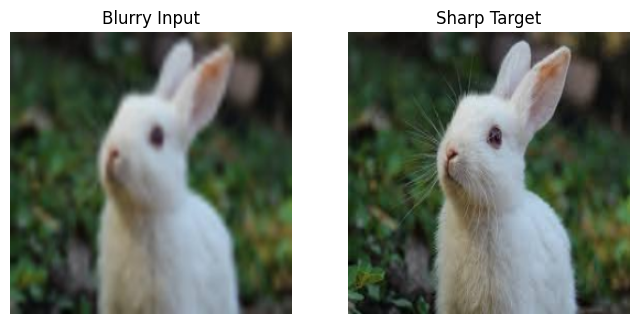

In [ ]:
# Show blurry vs sharp image
sample_blurry, sample_sharp = dataset[0]

def show_image(tensor_img, title):
    img = tensor_img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
show_image(sample_blurry, "Blurry Input")
plt.subplot(1, 2, 2)
show_image(sample_sharp, "Sharp Target")
plt.show()


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)  # <- input: 128 (upsampled) + 128 (skip)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)   # <- input: 64 (upsampled) + 64 (skip)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)               # [B, 64, 256, 256]
        enc2 = self.encoder2(self.pool1(enc1))# [B, 128, 128, 128]

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2)) # [B, 256, 64, 64]

        # Decoder
        up2 = self.upconv2(bottleneck)        # [B, 128, 128, 128]
        dec2 = self.decoder2(torch.cat([up2, enc2], dim=1)) # [B, 128, 128, 128]
        print("bottleneck shape:", bottleneck.shape)
        print("up2 shape:", up2.shape)
        print("enc2 shape:", enc2.shape)

        up1 = self.upconv1(dec2)              # [B, 64, 256, 256]
        dec1 = self.decoder1(torch.cat([up1, enc1], dim=1)) # [B, 64, 256, 256]

        return self.final(dec1)               # [B, 3, 256, 256]


In [ ]:
teacher = UNet().cuda()
teacher.eval()
for param in teacher.parameters():
    param.requires_grad = False


In [ ]:
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # input: [B, 3, H, W]
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, padding=1),   # output: [B, 3, H, W]
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize Student Model
student = StudentCNN().cuda()


In [ ]:
# Register hooks on specific layers

# For teacher UNet model
teacher.encoder1[0].register_forward_hook(get_activation('enc1', teacher_features))
teacher.encoder2[0].register_forward_hook(get_activation('enc2', teacher_features))

# For student CNN model
student.model[0].register_forward_hook(get_activation('conv1', student_features))
student.model[2].register_forward_hook(get_activation('conv2', student_features))


In [ ]:
sample_input = sample_blurry.unsqueeze(0).cuda()  # Add batch dimension
with torch.no_grad():
    teacher_out = teacher(sample_input)
    student_out = student(sample_input)

print("Shapes:")
print("Teacher output:", teacher_out.shape)
print("Student output:", student_out.shape)


bottleneck shape: torch.Size([1, 256, 64, 64])
up2 shape: torch.Size([1, 128, 128, 128])
enc2 shape: torch.Size([1, 128, 128, 128])
Shapes:
Teacher output: torch.Size([1, 3, 256, 256])
Student output: torch.Size([1, 3, 256, 256])


In [ ]:
# L1 Loss (Reconstruction Loss)
reconstruction_loss = nn.L1Loss()

# Perceptual Loss using pretrained VGG16
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg16(pretrained=True).features[:16]  # Use first few layers
        self.vgg = vgg.cuda()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, img1, img2):
        f1 = self.vgg(img1)
        f2 = self.vgg(img2)
        return nn.functional.l1_loss(f1, f2)

perceptual_loss = PerceptualLoss()

# Feature Distillation Loss (compare internal features of student & teacher)
def extract_features(model_seq, x, layer_ids=[2, 4]):
    features = []
    for i, layer in enumerate(model_seq):
        x = layer(x)
        if i in layer_ids:
            features.append(x)
    return features

# Real feature distillation loss
def feature_distillation_loss():
    loss = 0
    for key in student_features:
        if key in teacher_features:
            s_feat = student_features[key]
            t_feat = teacher_features[key]
            loss += nn.functional.l1_loss(s_feat, t_feat.detach())
    return loss

In [ ]:
perceptual_model = PerceptualLoss()

def total_loss_fn(student_out, sharp_img, teacher_out,
                  alpha=1.0, beta=0.1, gamma=0.1):
    l1 = reconstruction_loss(student_out, sharp_img)
    perceptual_val = perceptual_model(student_out, teacher_out)
    distill_val = feature_distillation_loss()

    total = alpha * l1 + beta * perceptual_val + gamma * distill_val
    return total, l1, perceptual_val, distill_val


In [ ]:
# Optimizer (only for student)
optimizer = optim.Adam(student.parameters(), lr=1e-4)

# Training Loop
num_epochs = 10  # You can increase later
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    student.train()
    epoch_loss = 0

    for batch_idx, (blurry_imgs, sharp_imgs) in enumerate(dataloader):
        # Clear old hooks
        teacher_features.clear()
        student_features.clear()
        blurry_imgs = blurry_imgs.to(device)
        sharp_imgs = sharp_imgs.to(device)

        # Forward passes
        with torch.no_grad():
            teacher_outputs = teacher(blurry_imgs)

        student_outputs = student(blurry_imgs)

        # Calculate total loss
        total_loss, l1, perceptual, distill = total_loss_fn(
            student_outputs,
            sharp_imgs,
            teacher_outputs,
            student,
            teacher,
            blurry_imgs
        )

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

        # Print batch stats
        if (batch_idx + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{len(dataloader)}] "
                  f"| Total Loss: {total_loss.item():.4f} | L1: {l1.item():.4f} | Perceptual: {perceptual.item():.4f} | Distill: {distill.item():.4f}")

    print(f"✔️ Epoch [{epoch+1}] finished with Avg Loss: {epoch_loss / len(dataloader):.4f}\n")


In [ ]:
# Convert torch tensor [C,H,W] to numpy [H,W,C]
def tensor_to_image(tensor):
    img = tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
    img = np.clip(img, 0, 1)
    return img


In [ ]:
student.eval()

# Pick a few samples
num_samples = 3

for i in range(num_samples):
    blurry, sharp = dataset[i]
    blurry_input = blurry.unsqueeze(0).cuda()  # add batch

    with torch.no_grad():
        output = student(blurry_input)

    pred = output.squeeze(0)  # remove batch

    # Convert all to image format
    blurry_img = tensor_to_image(blurry)
    sharp_img = tensor_to_image(sharp)
    output_img = tensor_to_image(pred)

    # Calculate SSIM
    ssim_score = ssim(sharp_img, output_img, channel_axis=-1, data_range=1.0)

    # Display
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(blurry_img)
    plt.title("Blurry Input")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(output_img)
    plt.title(f"Student Output\nSSIM: {ssim_score:.4f}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sharp_img)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
